## Importando as bibliotecas utilizadas

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import distance as dist
from imutils.perspective import four_point_transform
from imutils import contours
import imutils

##Lembrar de verificar quais libs nao estao sendo utilizada

## Função auxiliar para printar a imagem na tela

In [3]:
def show_image(image):
    plt.figure()
    plt.imshow(image)

## Transformando a imagem de exemplo em preto e branco (ou nesse caso, amarelo e roxo)

In [164]:
def limpa_imagem_oper_morfol(image, kernel_values):
    #image = cv2.imread(caminho_imagem)
    #Transformando a imagem em escala de cinza
    gray_scale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Revelando regioes mais escuras (ou seja, os digitos) do que a regiao claras (o fundo)
    thresh = cv2.threshold(gray_scale_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    #Limpando a imagem com operações morfologicas (Abertura e fechamento)
    #Foram testados diferentes valores para o kernel (2....9), sendo o 5 o melhor resultado
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_values)

    #Limpando a imagem com operações morfologicas (Abertura e fechamento)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
    return closing

### Com os filtros aplicados a imagem, vamos trabalhar em cima dela.

### Primeiro, aplicamos o filtro de contorno, em seguida, armazenamos o contorno dos digitos.
### Mostramos na tela os possiveis digitos contornados.

### Retorna uma imagem com os contornos dos possiveis dígitos e uma lista dos contornos dos dígitos

In [215]:
def encontra_digitos_image(imagem_transform_morfo, width, height):
    for_show_img_contor = imagem_transform_morfo.copy()
    #Aplicando o filtro de contorno e encontrando-os
    cnts = cv2.findContours(imagem_transform_morfo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    ##TESTEEEEEEEE
    #cv2.drawContours(imagem_transform_morfo, cnts, -1, (255, 255, 255), 1)

    #Lista para armazenar os contornos dos digitos
    digitCnts = []

    #Loops nos candidatos da area de digitos
    for c in cnts:
        #Calcula a "caixa" de um possivel digito
        (x, y, w, h) = cv2.boundingRect(c)
        #print(x, y, w, h)
        ###ESSE IF IMPACTA NO RESULTADDOOOOOOOOOOOOOOOOOOOOOOOOOOo
        if(w >= width and (h >= height)):
        #if(w >= 15 and (h >= 30 and h <= 40)):
            digitCnts.append(c)
            #Ultimo valor == espessura do retangulo
            #Pintando de verde (R, G, B)
            cv2.rectangle(for_show_img_contor, (x,y), (x+w, y+h), (100, 100, 100), 1)

    #Classificando os contos da esquerda para a direita (mesma direcao em que leriamos os digitos)
    digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
    return for_show_img_contor, digitCnts


## Com a lista de possiveis digitos feita, vamos agora identificar quais digitos são esses
### Temos um dicionário cuja a tupla é a chave de um digito em si. 
### A chave que indentificará qual é o possível dígito, é gerada dentro do for que caminha na lista de possíveis dígitos, calculando a altura e largura extraindo os sete segmentos do dígito. Verificando se determinado segmento está ligado ou não, e com base nisso, conseguindo identificar qual dígito ele é.

In [211]:
def classifica_digitos(image, imagem_limpa, lista_digitos):
    #image = cv2.imread(caminho_imagem_original)
    #Dicionario cujo a chave eh uma tupla que indica qual numero ele eh
    #O NUMERO DOIS ESTAVA COM A TUPLA ERRADA
    DIGITS_LOOKUP = {
        (1, 1, 1, 0, 1, 1, 1): 0,
        (0, 0, 1, 0, 0, 1, 0): 1,
        (1, 0, 1, 1, 1, 0, 1): 2,
        (1, 0, 1, 1, 0, 1, 1): 3,
        (0, 1, 1, 1, 0, 1, 0): 4,
        (1, 1, 0, 1, 0, 1, 1): 5,
        (1, 1, 0, 1, 1, 1, 1): 6,
        (1, 0, 1, 0, 0, 1, 0): 7,
        (1, 1, 1, 1, 1, 1, 1): 8,
        (1, 1, 1, 1, 0, 1, 1): 9
    }
    digits = []
    #Armazenando uma copia da imagem original em output, para mostrar a saida
    output = image.copy()
    #Loop em cada um dos digitos
    for c in lista_digitos:
        #Para cada uma das regioes, calculamos a caixa delimitadora e extraimos o digito ROI
        (x, y, w, h) = cv2.boundingRect(c)
        print(f"W:{w}, H:{h}")

        #Largura e altura aproximadas de cada segmento com base nas dimensoes do ROI
        roi = imagem_limpa[y:y + h, x:x + w]

        (roiH, roiW) = roi.shape
        (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
        dHC = int(roiH * 0.05)

        #Lista de (x, y) coordenadas que correspondem aos sete segmentos
        segments = [
            ((0, 0), (w, dH)),                           # top
            ((0, 0), (dW, h // 2)),                      # top-left
            ((w - dW, 0), (w, h // 2)),                  # top-right
            ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
            ((0, h // 2), (dW, h)),	                     # bottom-left
            ((w - dW, h // 2), (w, h)),                  # bottom-right
            ((0, h - dH), (w, h))                        # bottom
        ]

        #Lista que informa se determinado segmento esta ligado. Valor 0 == segmento desligado
        #[0, 0, 0, 0, 0, 0, 0]
        on_list = [0] * len(segments)

        #Loop sobre os segmentos
        for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
            #Extraindo o ROI do segmento
            segROI = roi[yA:yB, xA:xB]
            
            #Numero de pixels do segmento q estao "ligados"
            total = cv2.countNonZero(segROI)
            area = (xB - xA) * (yB - yA)
            #print("TOTAL: %f. AREA: %f" %(total, area/2))
            #show_image(segROI)
            #Se a proporcao de pixels diferentes de 0 para a area do segmento 
            #for maior que 50% => O segmento estao ligado

            if(total / float(area)) > 0.5:
                on_list[i] = 1

        #IF Necessario para casos de erro
        print(tuple(on_list) )
        if(tuple(on_list) in DIGITS_LOOKUP.keys()):
            digit = DIGITS_LOOKUP[tuple(on_list)]
            digits.append(digit)
        else:
            #NF == NOT FOUND
            digit = 'NF'
            digits.append('NF')

        #Desenhando uma caixa em torno do digito e exibindo qual digito ele eh
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        cv2.putText(output, str(digit), (x+10,y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    return output, digits

# Executando o teste base

W:36, H:62
(1, 0, 1, 1, 0, 1, 1)
W:36, H:56
(0, 1, 1, 1, 0, 1, 0)
W:33, H:61
(1, 1, 0, 1, 0, 1, 1)
[3, 4, 5]


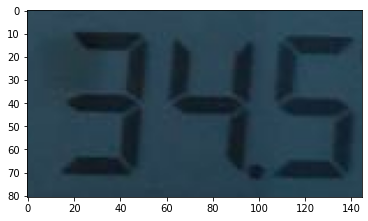

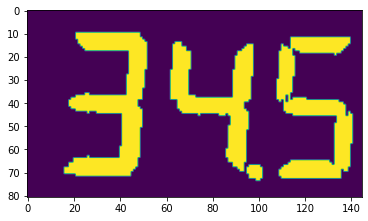

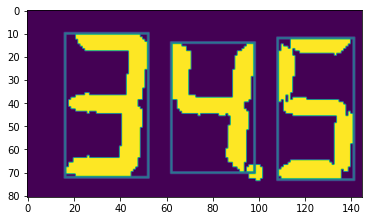

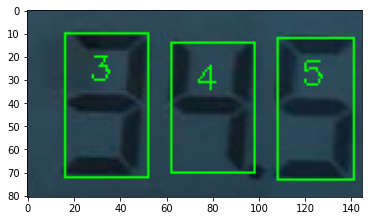

In [219]:
def exec_teste():
    imagem_exemplo = "ex.png"
    #Lendo a imagem
    img = cv2.imread(imagem_exemplo)
    show_image(img)

    #Limpando a imagem
    #Imagem e valores do kernel
    clean_image = limpa_imagem_oper_morfol(img, (1,3))
    show_image(clean_image)

    #Encontrando os possiveis digitos
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 10, 3)
    show_image(img_possiveis_digitos)
    #Identificando os possiveis digitos
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos)
    show_image(res_img)
    print(res_digits)
exec_teste()

## Dado que nem todas as imagens terão a mesma dimensão, é necessário uma função para identificar e recortar a parte de onde os dígitos estão

In [220]:
def cut_image(img):
    #image = cv2.imread(caminho_imagem)
    image = imutils.resize(img, height=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 200, 255)
    
    ##ISSO DAQUI EH NOVO -> DA ERRRO!!!!!!!!!!!
    #edged = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,87,9)
    
    #show_image(edged)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        if(len(approx) == 4):
            displayCnt = approx
            break
    warped = four_point_transform(gray, displayCnt.reshape(4, 2))
    output = four_point_transform(image, displayCnt.reshape(4, 2))
    
    return edged, output

# Executando a primeira base de testes

## Com a dilatação ligada em 4, o número '9' é reconhecido

W:33, H:49
(1, 0, 1, 1, 1, 0, 1)
W:22, H:49
(1, 0, 1, 0, 0, 0, 0)
W:10, H:48
(0, 0, 1, 0, 1, 0, 0)
W:33, H:49
(1, 0, 1, 1, 1, 0, 1)
[2, 'NF', 'NF', 2]


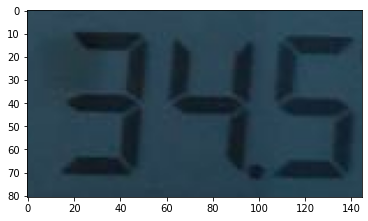

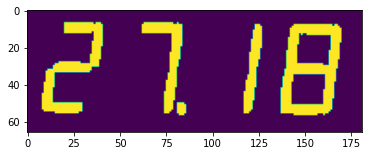

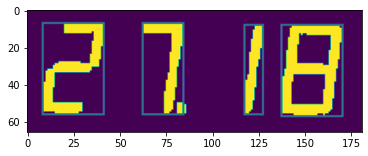

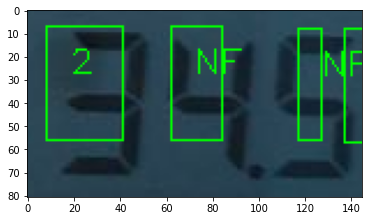

In [237]:
#INVERTER AS CORES TBM
def teste_limpa_imagem_oper_morfol(image, kernel_values):
    #image = cv2.imread(caminho_imagem)
    #Transformando a imagem em escala de cinza
    gray_scale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_scale_image = cv2.bitwise_not(gray_scale_image)
    #Revelando regioes mais escuras (ou seja, os digitos) do que a regiao claras (o fundo)
    thresh = cv2.threshold(gray_scale_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    #Limpando a imagem com operações morfologicas (Abertura e fechamento)
    #Foram testados diferentes valores para o kernel (2....9), sendo o 5 o melhor resultado
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_values)

    #Limpando a imagem com operações morfologicas (Abertura e fechamento)
    #teste = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    #teste = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    
    #Dilatacao
    #teste = cv2.dilate(thresh, kernel, iterations=1)
    
    #Erosao
    #teste = cv2.erode(thresh, kernel, iterations=1)
    
    #Dilatacao
    #teste = cv2.dilate(thresh, kernel, iterations=1)
    
    #Top Hat
    #teste = cv2.morphologyEx(thresh, cv2.MORPH_TOPHAT, kernel)
    
    return teste


def exec_base1():
    #imagem_exemplo = "./Base1/unnamed3.png"
    #imagem_exemplo = "./Base2/ex6.jpg"
    imagem_exemplo = "ex.png"

    #Lendo a imagem
    img = cv2.imread(imagem_exemplo)
    show_image(img)
    
    #Limpando a imagem
    clean_image = teste_limpa_imagem_oper_morfol(img, (1,7))
    show_image(clean_image)


    #Encontrando os possiveis digitos
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 9, 2)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos)
    show_image(res_img)
    print(res_digits)
    
exec_base1()

# TESTE DA BASE 2

ValueError: not enough values to unpack (expected 2, got 0)

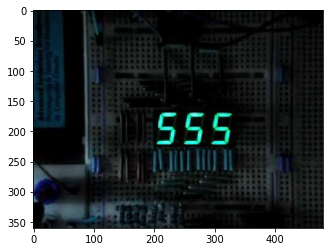

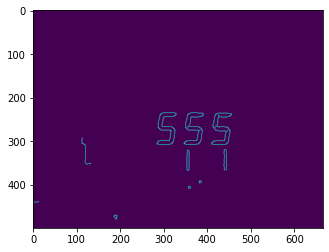

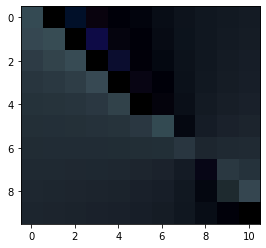

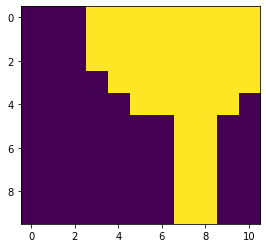

In [213]:
def teste_limpa_imagem_oper_morfol(image, kernel_values):
    #image = cv2.imread(caminho_imagem)
    #Transformando a imagem em escala de cinza
    gray_scale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_scale_image = cv2.bitwise_not(gray_scale_image)
    #Revelando regioes mais escuras (ou seja, os digitos) do que a regiao claras (o fundo)
    thresh = cv2.threshold(gray_scale_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    #Limpando a imagem com operações morfologicas (Abertura e fechamento)
    #Foram testados diferentes valores para o kernel (2....9), sendo o 5 o melhor resultado
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_values)

    #Limpando a imagem com operações morfologicas (Abertura e fechamento)
    #teste = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    #teste = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    
    #Dilatacao
    #teste = cv2.dilate(thresh, kernel, iterations=1)
    
    #Erosao
    teste = cv2.erode(thresh, kernel, iterations=1)
    
    #Dilatacao
    teste = cv2.dilate(thresh, kernel, iterations=1)
    
    #Top Hat
    #teste = cv2.morphologyEx(thresh, cv2.MORPH_TOPHAT, kernel)
    
    return teste


#imagem_exemplo = "./Base1/unnamed3.png"
imagem_exemplo = "./Base2/ex12.jpg"
#imagem_exemplo = "ex.png"

#Lendo a imagem
img = cv2.imread(imagem_exemplo)
show_image(img)


#Cortando a imagem
img_bordas, imagem_cortada = cut_image(img)
show_image(img_bordas)
show_image(imagem_cortada)

#Limpando a imagem
#clean_image = limpa_imagem_oper_morfol(img, (1,1))
clean_image = limpa_imagem_oper_morfol(imagem_cortada, (1,5))
#clean_image = cv2.bitwise_not(clean_image)
show_image(clean_image)

#show_image(teste)

#Encontrando os possiveis digitos
img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 10, 3)
show_image(img_possiveis_digitos)

#Identificando os possiveis digitos
res_img, res_digits = classifica_digitos(imagem_cortada, clean_image, possiveis_digitos)
show_image(res_img)
print(res_digits)

'''
#Lendo a imagem
img = cv2.imread(imagem_exemplo)
show_image(img)

#Cortando a imagem
img_bordas, imagem_cortada = cut_image(img)
show_image(img_bordas)
show_image(imagem_cortada)

#Limpando a imagem
clean_image = limpa_imagem_oper_morfol(imagem_cortada)
show_image(clean_image)

#Encontrando os possiveis digitos
img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image)
show_image(img_possiveis_digitos)

#Identificando os possiveis digitos
res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos)
show_image(res_img)
print(res_digits)
'''

